# Complex Weight Initializations
> Building complex-valued layers with Rayleigh initializations.  

- toc: true 
- badges: true
- comments: true
- categories: [deep learning, complex networks]
- image: images/polar_plot.png

In [ ]:
#| default_exp complexRayleighInit

# Overview

This post describes how to create weight initialization for complex-valued neural networks.  
<br>
As a refresher, a complex number has both a real and imaginary components. These two parts define a vector that can be perfectly described by two values: its *magnitude* and its *phase*. 
- **Magnitude**: the length of a vector.
- **Phase**: the angle, or direction, that the vector points in. 
<br>  

Most neural networks use real-valued numbers instead of complex ones. These real-valued networks include NLP networks like Transformers for text, CNNs in Computer Vision for images, and feed-forward networks for audio signals like speech. When initializing all of these neural networks, each weight only needs a single, real-valued number. The networks for these tasks and domains have been incredibly successful, so why would need complex-valued weights in the first place? 

It turns our that signals are more naturally represented in the complex domain: robotics, Radio Frequency communications, bio-informatics, radar, and even speech. That is not to say we *must* use complex values for these signals. In fact real-valued networks have been used in these domains. The crucial detail is that they are technically throwing away half of the potential input data. Moreover, the phase of signals often contains important information: the phase of an image describes the actual position of the photo's subjects, while the magnitude mainly contains color information. In speech, the phase of a signal is important for how understandable the audio is. In communication, sonar, radar, and robotics signals the phase carries information about both the content and location of signals. 

If we want to leverage the full potential of these complex-valued input signals, we need to match them with complex-valued neural networks. The main difference for initialization is that we need now need two values: one for phase and the other for the magnitude. But we can't just take two regular, real-valued initializations and call it a day. The rest of this post covers the details of how to accurately create the correct type of complex-valued weight initializations.  



## Specifics of complex-valued initializations. 

To make things more concrete, the magnitudes will be drawn from a specific kinds of distribution called a **[Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution])**. The reasons for this are described later, but for now just think of it as the complex-version of the familiar Random or Normal distributions we use to initialize real-valued weights.  

The phases will be drawn from a Uniform distribution. If you think about a compass, there are 360 degrees to choose from. We could randomly pick a degree and start walking in that direction. Assuming we are on a mostly flat surface, for each degree we will end up in a different, unique location. Because we don't know which direction our learned complex-valued weights should point in, the best we can do is start randomly pointing everywhere and let the gradients steer the vectors instead.  

# Background on initializations 

Now we know how to pick (aka sample) both the magnitude and phase of our complex-valued weights.  

But! There is another important step. While initializations are now taken for granted, they were one of the first key pieces that made it possible to train deep neural networks in the first place. In the early attempts to train neural networks, before we knew what made for good initializations, the gradients and weight values would either diverge or collapse to 0. This was known as gradient explosion and vanishing, respectively.  

The main insights about how to prevent gradients from vanishing or exploding came from inspecting their variance during training. (As an aside: this remains an important error analysis tool even today! Looking at the behavior and distribution of gradients is a surefire way to find problems, if there are any, with the training. Especially during the earliest learning steps).    

It was the following great work by [He](https://arxiv.org/pdf/1502.01852.pdf) and [Glorot, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) that showed how the variance of the weights must meet certain criteria to ensure that gradients flow smoothly. Here, "smoothly" means that during training the gradients neither disappeared (went to 0) nor exploded (grew without bound).  The best-known initializations described in these papers are now the defaults in popular deep learning libraries like TensorFlow and pytorch.  

However, the theory of complex-valued neural networks is newer and not as well established. Thankfully, we can borrow the lessons above about good initializations to make sure the gradients of our complex-valued weights are well-behaved and allow the networks to converge and learn.    

# Complex networks

Despite the fact that they are not as popular as real-valued approaches, complex-valued networks actually have a rich, long history. See [Chapter 3 of this thesis](https://www.cs.dartmouth.edu/~trdata/reports/TR2018-859.pdf) for a great recap.  

The first modern and complete take on deep complex neural nets was [Deep Complex Networks](https://arxiv.org/pdf/1705.09792.pdf) by Trabelsi et. al. This paper explored many fundamental building blocks for deep complex networks. It developed the following pieces: initializations, convolutions, activations, batch normalizations, and stacked them together to build complex Residual Networks (ResNets).  

Despite this fantastic work the field stayed quiet at first. But, there has been a recent spike in activity with follow ups in: medical imaging, radio frequency signal processing, physical optical networks, and even some quantum networks! Some of the applications and advances in this domain are detailed in this more recent, comprehensive [Survey of Complex-Valued Neural Networks](https://arxiv.org/pdf/2101.12249.pdf) by Bassey at. al.  
<br>  

Now that we know a bit more about complex-valued networks, we are ready to initialize their weights.  

# Rayleigh Distribution  



In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.random import RandomState

To best describe a Rayleigh distribution, imagine setting up a wind-speed sensor out in an open field. If we analyze the wind passing through this sensor in two directions, say North and East, then the magnitude of the wind's velocity will be Rayleigh distributed.  

More generally, this distribution happens when two random variables are added together. To be Rayleigh distributed, the random variables must be uncorrelated, normally distributed, have zero mean, and share the same standard deviation.  

Another example of a Rayleigh distribution is tuning in to a radio signal. Imagine we tune a radio to an empty RF spectrum region where all we hear is noise. If we record the real and imaginary components of this RF noise, then its magnitude will follow a Rayleigh distribution.
<br>  

We chose the Rayleigh distribution because, without knowing more information about our complex-valued magnitudes, it is a good unbiased starting point from which the network can then learn better values. 


Let's dive into the details. The equation below is the Probability Density Function (PDF) of a Rayleigh distribution.

$$f(x,\sigma) = \frac{x}{\sigma^2}e^{-x^2/(2\sigma^2)}, \ \ x \geq 0$$

If this equation looks intimidating, we can instead code it up as a python function using the NumPy library to make it much cleaner:

In [ ]:
#| export
def rayleigh_pdf(x, sigma):
    "Evaluates the Rayleigh PDF at a given point `x`."
    p = (x / sigma**2) * np.exp(-x**2 / (2*sigma**2)) # see if you can match this code to the equation above
    return p

In the equation and code above sigma ($\sigma$) is known as the scale parameter. It is common in many probability distributions and usually controls how spread out or narrow a distribution is.

Let's start by setting $\sigma = 1$ to see the "basic" Rayleigh shape. We will then change sigma to see how it affects the distribution.

In [ ]:
#| export

# start with sigma of one as the base case
sigma = 1

# calculate the Rayleigh PDF on 100 equally spaced points between 0 and 5
points = np.linspace(0, 5, 100)
ray_pdf = rayleigh_pdf(points, sigma)

/tmp/ipykernel_10685/4025282375.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))


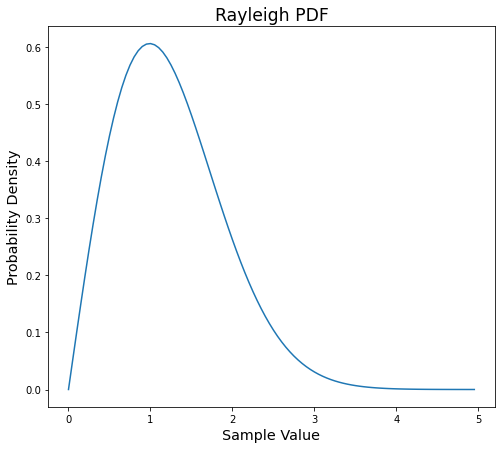

In [ ]:
#| export

# plot the Rayleigh pdf
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(ray_pdf)
ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))
ax.set_xlabel('Sample Value', fontsize='x-large')
ax.set_ylabel('Probability Density', fontsize='x-large')
ax.set_title('Rayleigh PDF', fontsize='xx-large');

As we mentioned the scale, $\sigma$, changes the width or narrowness of the distribution. Let's both halve and double sigma to ($\frac{1}{2}, {2})$ respectively to see what happens.

/tmp/ipykernel_10685/2127029125.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))


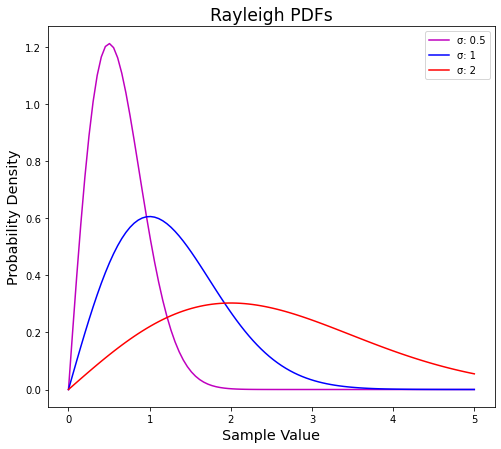

In [ ]:
# setup plot
fig,ax = plt.subplots(figsize=(8,7))
ax.set_xlabel('Sample Value', fontsize='x-large')
ax.set_ylabel('Probability Density', fontsize='x-large')
ax.set_title('Rayleigh PDFs', fontsize='xx-large'); 


# different colors for each sigma
sigmas = [0.5, 1, 2]
colors = ['m', 'b', 'r']

# plot the distributions
for color,sig in zip(colors,sigmas):
    rpdf = rayleigh_pdf(points, sig)
    ax.plot(points, rpdf, c=color, label=f'σ: {sig}')
ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))
ax.legend();

The blue line in the plot above is the same PDF from our first plot where $\sigma = 1$.  

We can see how $\sigma = 0.5$ pulls the distribution up and to the left, while $\sigma = 2$ squishes it down and to the right.  

In other words, a smaller sigma makes our distribution narrower while a larger sigma makes it wider.

Plotting the theoretical Rayleigh PDF only showed us what the distribution *should* looks like. Now, we need to actually generate the Rayleigh values.

# Generating Rayleigh samples

We will use the [RandomState](https://numpy.org/doc/stable/reference/random/legacy.html?highlight=numpy%20random%20randomstate#numpy.random.RandomState) class in the numpy library to generate Rayleigh samples. RandomState is a helpful class that can sample from just about every known distribution.

First we create the RandomState class with the chosen seed of $0$.

In [ ]:
#| export
seed = 0
rand = RandomState(seed)

This helpful `RandomState` instance can now directly sample from a Rayleigh distribution. We use the sampling function `RandomState.rayleigh` which accepts two parameters:
- `scale`: $\sigma$ with a default value of 1.
- `size`: the shape of the output array  
<br>

Let's start by drawing 1,000 Rayleigh samples with $\sigma = 1$. 

In [ ]:
#| export
sigma = 1
shape = 1000
# one dimensional vector with 1000 samples
ray_vals = rand.rayleigh(scale=sigma, size=shape)

How to check if these samples are actually Rayleigh distributed?
We can refer back to our PDF plots at the beginning, which tell us how Rayleigh samples should be "spread out". The easiest way to check if these samples are spread out as expected is with a histogram.

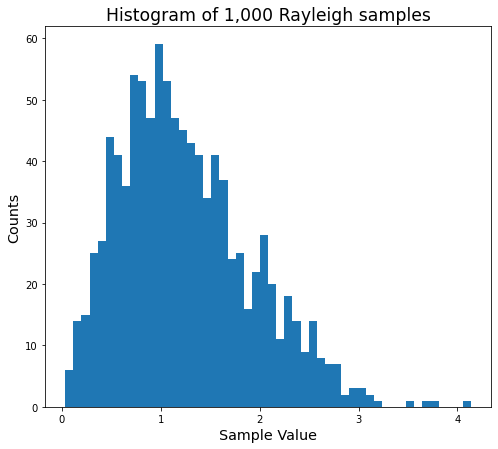

In [ ]:
#| export
# plot histogram of 1000 drawn samples
plt.figure(figsize=(8,7))
plt.hist(ray_vals, bins=50)
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Counts', fontsize='x-large')
plt.title(f'Histogram of {shape:,} Rayleigh samples', fontsize='xx-large');

This is an ok start. If we squint, we can somewhat see the PDF outline shape we plotted earlier. But, 1000 samples isn't that much.  

As we draw more samples the distribution should get even closer to the earlier PDF plots. Let's make sure this happens by now drawing 10,000 samples.

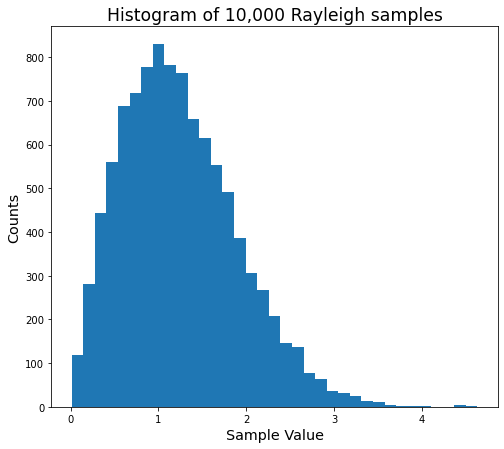

In [ ]:
#| export
large_shape = 10000
many_ray_vals = rand.rayleigh(scale=sigma, size=large_shape)
plt.figure(figsize=(8,7))
plt.hist(many_ray_vals, bins=35);
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Counts', fontsize='x-large')
plt.title(f'Histogram of {large_shape:,} Rayleigh samples', fontsize='xx-large');

Much better! Let's compare this histogram against the theoretical Rayleigh PDF.  

Note that we pass `density=True` to the histogram function below to make it approximate the PDF.

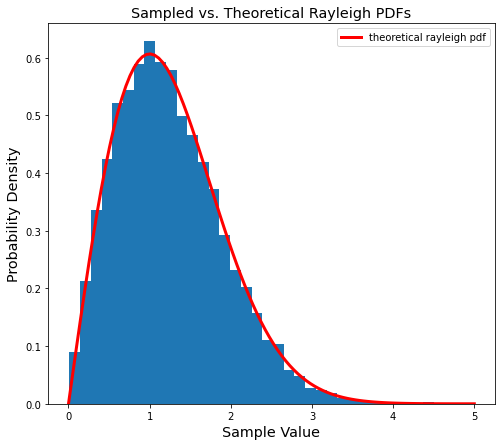

In [ ]:
#| export
# setup the plot again
plt.figure(figsize=(8,7))
plt.title('Sampled vs. Theoretical Rayleigh PDFs', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')


# compare theoretical vs. sampled Rayleigh PDFs
plt.hist(many_ray_vals, density=True, bins=35) # makes the histogram sum to one, to mimic pdf
plt.plot(points, ray_pdf, c='r', label='theoretical rayleigh pdf', linewidth=3)
plt.legend();

A perfect match! 

Now that we can generate our initial complex magnitudes, let's move on to the phase.  

# Adding phase information

The Rayleigh samples from above give us the magnitude, or length, of the complex weights. But that is only one part of a complex number. We are still missing information about the phase, or angle. The phase tells us in which direction a vector is pointing.  

For our purposes it is enough to use random angles. Why? Many processes such as speech, images, and RF modulations encode information in phase. But we don't know what this pointing should look like beforehand, and we do not want to bias the networks to any particular phase setup. Instead, uniformly picking a starting phase is like starting with many vectors fanned out in all directions. Then, during training, the network will learn how to best both orient and scale the weights for its task. 

Adding this random uniform phase is straightforward. We pick uniform samples from $-\pi$ to $\pi$ radians which maps to a full loop of the unit circle. We can even reuse the same `RandomState` from before!

In [ ]:
#| export

# pick random directions along the unit circle
phase = rand.uniform(low=-np.pi, high=np.pi, size=ray_vals.shape)

We mentioned earlier that a complex number has a real and imaginary component. But so far we've talked about magnitude and phases instead. How are they related?  

It turns out we can use the phase together with the magnitude to split our vector into real and imaginary part. We use the cosine of the phase for the real part, and the sine of the phase for the imaginary part. These are two different representations of the same complex number, we don't lose anything going from one to the other or vice-versa.

In [ ]:
#| export
real = ray_vals * np.cos(phase)
imag = ray_vals * np.sin(phase)

Now we can check if these complex valued weight vectors are truly pointing in random directions. To do this we can plot the first 500 complex weights in the complex plane.

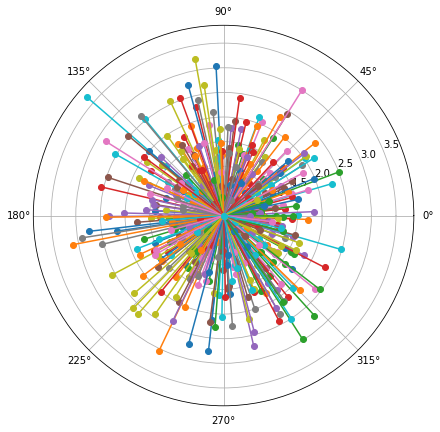

In [ ]:
#| export

# indexes for the first 500 random weights
chosen_samples = range(500) 

# plot these first complex weights
plt.figure(figsize=(8,7))
for idx in chosen_samples:

    # index into phase and magnitude variables
    angle,mag = phase[idx],ray_vals[idx]

    # plot them starting from the origin
    plt.polar([0,angle], [0,mag], marker='o')

We are almost there! To recap, we now have:  
- Random magnitude initializations drawn from a Rayleigh distribution. 
- Random phase initializations drawn from a Uniform distribution.  

Combined, these give us random complex-valued vectors that are pointing in roughly random directions.  

There is only one missing piece: making sure that these complex weights are well-behaved during training. 

# Matching He and Glorot variance criteria

Even though we now have real and imaginary components, they are not quite good initializations yet. The polar plot above gives some clues as to why (hint: look at the range of magnitudes in the vectors).  

Recall from the earlier section on initializations: the key insight was that the variance of the weights needs to meet certain criteria. This criteria helps the gradients flow well during backpropagation.  

To be more specific, both the He and Glorot criteria are based on the incoming and outgoing connections of a network layer. The number of connections are typically called `fanIn` and `fanOut`, respectively.  

The He criteria says that the variance of weights $W$ should be: $$\text{Var}(W) = \frac{2}{\text{fanIn}}$$

The Glorot criteria says that the variance should be: $$\text{Var}(W) = \frac{2}{\text{fanIn + fanOut}}$$

Deep networks typically have hundreds or thousands of connections. In practice this means that the variance of the weights will be very small. Now we can see why the values in the earlier polar plot are not good: their variance is clearly too large!

So how can we make sure our Rayleigh magnitudes meet the He and Glorot variance criteria?  
The [Complex Neural Nets paper](https://arxiv.org/pdf/1705.09792.pdf) from earlier includes a nice derivation for the variance of a complex Rayleigh distribution: $$\text{Var}(W) = 2\sigma^{2}$$   

We can then set this Rayleigh variance equal to the He and Glorot criteria and solve for sigma.

To meet the He criteria, sigma should be: $$\sigma_{\text{He}} = \frac{1}{\sqrt{\text{fanIn}}}$$ <br>

To meet the Glorot criteria, sigma should be: $$\sigma_{\text{Glorot}} = \frac{1}{\sqrt{\text{fanIn + fanOut}}}$$ <br>

Let's take a step back. In the earlier sections we used a flat vector of complex weights as an example. Tying it to our two concrete examples of wind speed and RF noise, it's as if we took a single series of velocity or noise measurements.  

Since the He and Glorot criteria are defined specifically for network layers, we now switch to a simple one-layer network as an example. Let's arbitrarily choose a layer with 100 inputs and 50 outputs (`fanIn` = 100, `fanOut` = 50).

Plugging these `fanIn` and `fanOut` values into the Rayleigh sigma criteria gives:
$$\sigma_{\text{He}} = \frac{1}{10}$$

$$\sigma_{\text{Glorot}} = \frac{1}{5\sqrt{6}}$$

That's all! Now we can pass either of these sigmas into our `RandomState` and it will draw Rayleigh samples that match the chosen variance criteria. Note that this only applies to the magnitude, we can leave the phase as-is.

# Putting it all together: A complex-valued PyTorch initializer

Here is a recap of the previous sections:
1. We drew a flat series of Rayleigh magnitudes to learn more about the distribution.
2. We picked a random phase component, then split the magnitudes into real and imaginary parts.
3. We saw how to match the He and Glorot variance criteria with Rayleigh samples for a single network layer.  

To make the above practical and usable, we need to automatically generate complex weigths that:
- Match the He/Glorot variance criteria
- Are PyTorch tensors
- Have the correct shape for the given network layer
<br>  

We can put all of the pieces above into a Python function that does this for us.  

> A quick word about `fanIn` and `fanOut`. We saw the simple feed-forward case with in our example for a single network layer. In that case the number of incoming connections was simply `fanIn` and the outgoing connections were `fanOut`.  

> However, the convolutional case is a bit more complicated. A convolutional layer has input and output feature maps which are roughly analogous to input and output units in feed-forward layers. But they also have a kernel size to consider. PyTorch has a nice [convenience function](https://pytorch.org/docs/stable/_modules/torch/nn/init.html#_calculate_fan_in_and_fan_out) that handles this for us. 

We can now refactor the earlier code into a function that automatically creates complex-valued Rayleigh weights given an input PyTorch module.

In [ ]:
#| export
def get_complex_inits(module, seed=None, criterion='he', dtype='float32'):
    """Initializes complex-valued Rayleigh weights as PyTorch tensors.
    """
    # random number generator
    rand = RandomState(seed if seed is None else torch.initial_seed())
    
    # get shape of the weights
    weight_shape = module.weight.size()
    
    # find the number of input and output connection
    fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(module.weight)
    
    # compute the Rayleigh sigma that meets the chosen variance criteria
    assert criterion in ('he','glorot')
    factor = fan_in if criterion == 'he' else fan_in + fan_out
    sigma = 1. / np.sqrt(factor)
    
    # draw the scaled rayleigh magnitudes
    magnitude = rand.rayleigh(scale=sigma, size=weight_shape)
    # draw uniform angle samples
    phase = rand.uniform(low=-np.pi, high=np.pi, size=magnitude.shape)
    
    # split magnitudes into real and imaginary components
    real = (magnitude * np.cos(phase)).astype(dtype)
    imag = (magnitude * np.sin(phase)).astype(dtype)
    
    # turn into float tensors and return
    real,imag = map(torch.from_numpy, [real,imag])
    return real,imag
    

## Complex initialization for a `nn.Linear` module

In [ ]:
#| export


# re-create out earlier example with a single layer
fan_in, fan_out = 100, 50
sigma_he = 1. / np.sqrt(fan_in)

# get the complex-valued weights
m = torch.nn.Linear(fan_in, fan_out)
real, imag = get_complex_inits(m)

Let's check if the weights are correctly distributed. Going back to our Rayleigh introduction, it is the magnitude that should be Rayleigh distributed.

In [ ]:
#| export

# grab magnitude as flat vector of numpy samples
magnitude = torch.sqrt(real**2 + imag**2).numpy().reshape(-1)

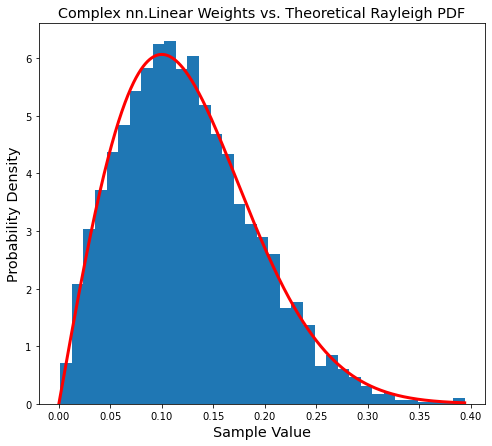

In [ ]:
#| export

# plot histogram of magnitudes vs. theoretical pdf
plt.figure(figsize=(8,7))
plt.title('Complex nn.Linear Weights vs. Theoretical Rayleigh PDF', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')

# pick points that cover the sample range to compare with theoretical rayleigh pdf
points = np.linspace(0, magnitude.max(), 1000)
ray_pdf = rayleigh_pdf(points, sigma=sigma_he)

plt.hist(magnitude, bins=35, density=True)
plt.plot(points, ray_pdf, c='r', linewidth=3);

Success!

## Testing on a `nn.Conv2d` module

What about a convolutional layer? Our main concern here is that both the tensor shape and `fan_in`/`fan_out` are handled correctly.

In [ ]:
#| export

# make conv layer with 100 input features, 50 output features, and (3x3) kernel

# set a 3x3 kernel size
k = 3 
conv_layer = torch.nn.Conv2d(fan_in, fan_out, k)
real_conv, imag_conv = get_complex_inits(conv_layer) # get the initial complex weights

# make sure the shape of weights is ok
print(f'Shapes of real and imaginary convolution tensors: {real_conv.shape}, {imag_conv.shape}')

Shapes of real and imaginary convolution tensors: torch.Size([50, 100, 3, 3]), torch.Size([50, 100, 3, 3])


Let's check if these convolutional weights are still Rayleigh distributed.

In [ ]:
#| export

# grab magnitude as flat vector of numpy samples
conv_magnitude = torch.sqrt(real_conv**2 + imag_conv**2).numpy().reshape(-1)

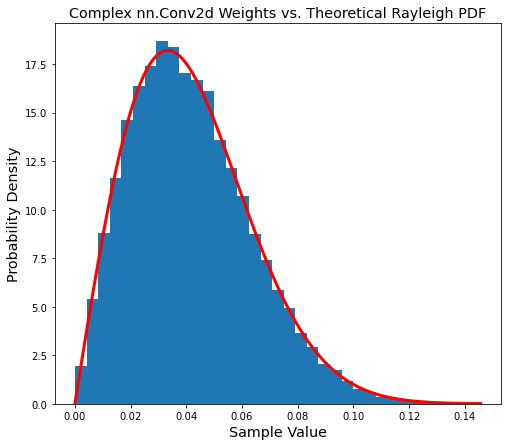

In [ ]:
#| export

# plot histogram of magnitudes vs. theoretical pdf
plt.figure(figsize=(8,7))
plt.title('Complex nn.Conv2d Weights vs. Theoretical Rayleigh PDF', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')


# pick points that cover sample range to compare with theoretical rayleigh pdf
points = np.linspace(0, conv_magnitude.max(), 1000)

# note: we need to re-compute fanIn for the convolutional layer
fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(conv_layer.weight)
sigma_he_conv = sigma=1. / np.sqrt(fan_in)

ray_pdf = rayleigh_pdf(points, sigma_he_conv)

# plot the two distributions
plt.hist(conv_magnitude, bins=35, density=True)
plt.plot(points, ray_pdf, c='r', linewidth=3);

Another success!

# Conclusion

In this post we created Rayleigh initializations for complex-valued neural networks. We started with an overview of the Rayleigh distribution. Next we used this distribution to create the magnitudes of complex-valued weights. We then added some phase information to randomly orient the vectors. After that, we made sure the weights matched a certain variance criteria to be good initializations.  

Finally, we put all tha together into a python function that returns pytorch tensors.  The function as is not quite ready for use in a fully fledged complex-valued setup, but we will get there.  

Part two will look at another type of complex initialization based on (semi) unitary matrixes. After that we will proceed to build complex convolutions and actvations.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()